<a href="https://colab.research.google.com/github/ahmetkrgztr/boun_mr_to_ct/blob/main/boun_mr_to_ct.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
!wget "https://heviai89-my.sharepoint.com/:u:/g/personal/ahmet_karagoz_hevi_ai/EZU8bpvxmcdAsXcVJRbW5fIBdq7QO4LPu_EKTqoK38fhbA?download=1" -O images_boun_DC.zip



--2023-11-02 12:14:21--  https://heviai89-my.sharepoint.com/:u:/g/personal/ahmet_karagoz_hevi_ai/EZU8bpvxmcdAsXcVJRbW5fIBdq7QO4LPu_EKTqoK38fhbA?download=1
Resolving heviai89-my.sharepoint.com (heviai89-my.sharepoint.com)... 13.107.136.10, 13.107.138.10, 2620:1ec:8f8::10, ...
Connecting to heviai89-my.sharepoint.com (heviai89-my.sharepoint.com)|13.107.136.10|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /personal/ahmet_karagoz_hevi_ai/Documents/images_boun_DC.zip?ga=1 [following]
--2023-11-02 12:14:22--  https://heviai89-my.sharepoint.com/personal/ahmet_karagoz_hevi_ai/Documents/images_boun_DC.zip?ga=1
Reusing existing connection to heviai89-my.sharepoint.com:443.
HTTP request sent, awaiting response... 200 OK
Length: 60310095 (58M) [application/x-zip-compressed]
Saving to: ‘images_boun_DC.zip’

images_boun_DC.zip  100%[===================>]  57.52M  15.4MB/s    in 3.7s    

2023-11-02 12:14:26 (15.4 MB/s) - ‘images_boun_DC.zip’ saved [60310095/60310095]

In [ ]:
!unzip /content/images_boun_DC.zip

# MR görüntülerinden BT görüntüsü sentezleme

*  Zaman, para ve hastayı koruma amacıyla gereksiz BT çekimlerinin önüne geçmek
*  Halihazırda MR'ı çekilmiş hastaların görüntülerinde BT sentezlemek

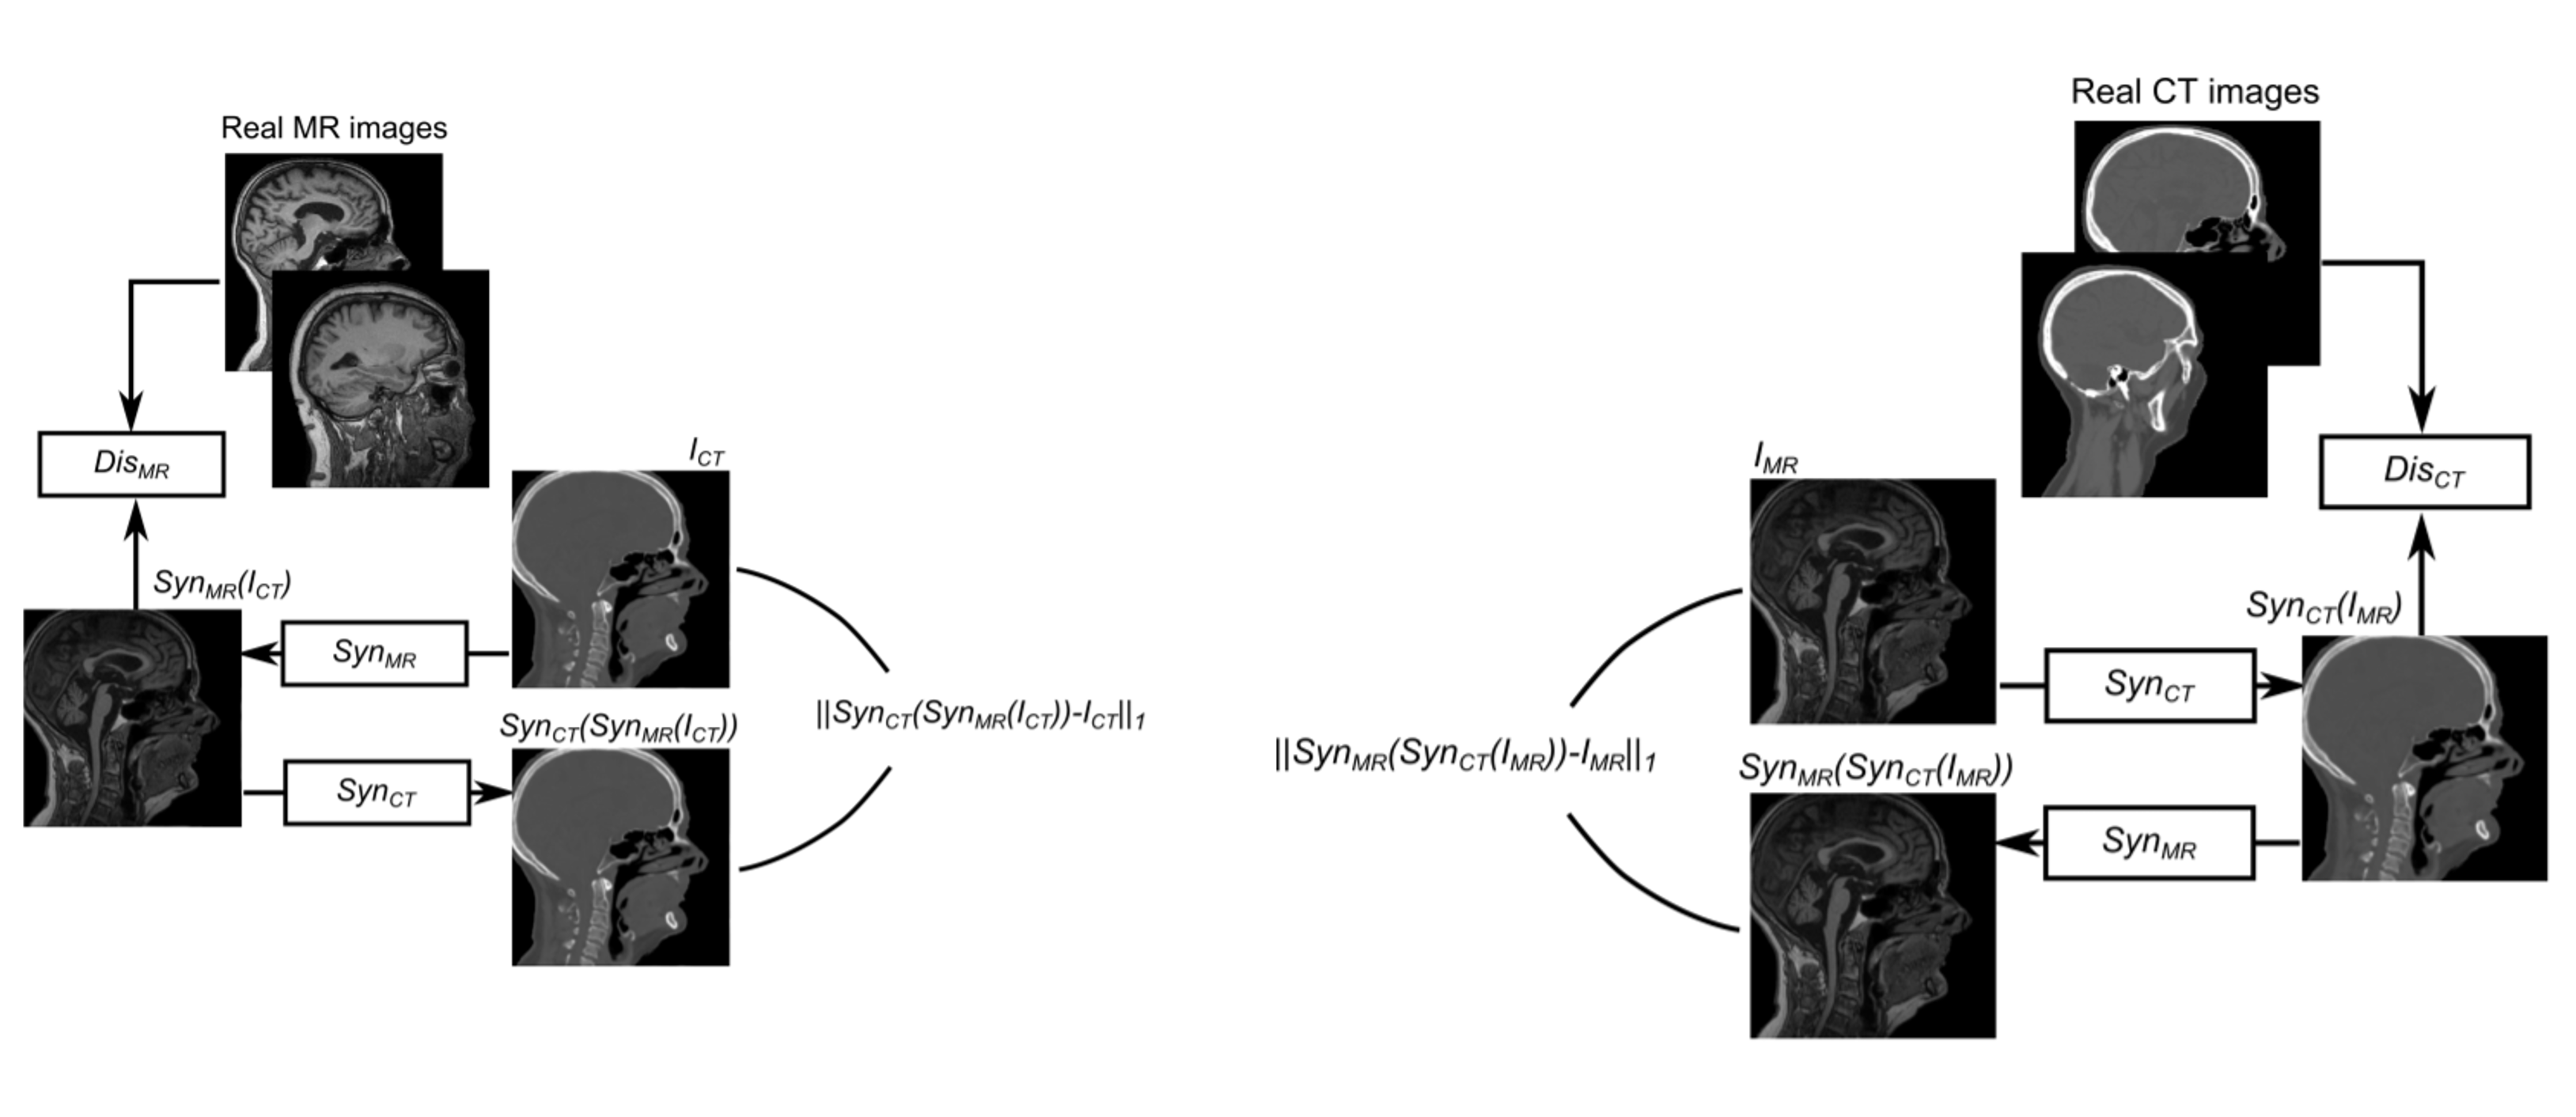

In [ ]:
Image(filename='./drive/MyDrive/notebook_images/back_and _forw.png',width=1200, height=500)

# Elimizdeki veriler:
  ##  Head CT ~20k
  ##  Head MR ~15k

In [16]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 17519665237806027296
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14357954560
locality {
  bus_id: 1
  links {
  }
}
incarnation: 17948529189830839416
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
xla_global_id: 416903419
]


In [17]:
!pip install git+https://github.com/tensorflow/examples.git



  Cloning https://github.com/tensorflow/examples.git to /tmp/pip-req-build-agnet31h
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/examples.git /tmp/pip-req-build-agnet31h
  Resolved https://github.com/tensorflow/examples.git to commit d639fe4b394c391dfdf6d00171cfa916a7fc1175
  Preparing metadata (setup.py) ... done


In [18]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow_examples.models.pix2pix import pix2pix
import os
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output
from PIL import Image
from albumentations import Resize
import numpy as np
from tqdm import tqdm

AUTOTUNE = tf.data.AUTOTUNE

In [19]:
BUFFER_SIZE = 1000
BATCH_SIZE = 1
IMG_WIDTH = 256
IMG_HEIGHT = 256


In [20]:
ct_data_dir = "images_boun_DC/CT/"

ct_train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  ct_data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(256, 256),
  batch_size=1)

ct_valid_ds = tf.keras.preprocessing.image_dataset_from_directory(
  ct_data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(256, 256),
  batch_size=1)

Found 2049 files belonging to 1 classes.
Using 1640 files for training.
Found 2049 files belonging to 1 classes.
Using 409 files for validation.


In [22]:
mri_data_dir = "images_boun_DC/MR_img/"

mri_train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  mri_data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(256, 256),
  batch_size=1)

mri_valid_ds = tf.keras.preprocessing.image_dataset_from_directory(
  mri_data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(256, 256),
  batch_size=1)

Found 3283 files belonging to 1 classes.
Using 2627 files for training.
Found 3283 files belonging to 1 classes.
Using 656 files for validation.


In [23]:
def random_crop(image):
    cropped_image = tf.image.random_crop(image, size=[IMG_HEIGHT, IMG_WIDTH, 3])
    return cropped_image

# normalizing the images to [-1, 1]
def normalize(image):
    image = tf.cast(image, tf.float32)
    image = (image / 127.5) - 1
    return image

def random_jitter(image):
    # resizing to 286 x 286 x 3
    image = tf.image.resize(image, [286, 286],
                          method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

    # randomly cropping to 256 x 256 x 3
    image = random_crop(image)

    # random mirroring
    image = tf.image.random_flip_left_right(image)

    return image

def preprocess_image_train(image, label):
    #image = random_jitter(image)
    image = normalize(image)
    return image

def preprocess_image_test(image, label):
    image = normalize(image)
    return image


In [24]:
ct_train_ds = ct_train_ds.map(
    preprocess_image_train, num_parallel_calls=8).cache().shuffle(
    BUFFER_SIZE)
mri_train_ds = mri_train_ds.map(
    preprocess_image_train, num_parallel_calls=8).cache().shuffle(
    BUFFER_SIZE)

ct_valid_ds = ct_valid_ds.map(
    preprocess_image_test, num_parallel_calls=8).cache().shuffle(
    BUFFER_SIZE)

mri_valid_ds = mri_valid_ds.map(
    preprocess_image_test, num_parallel_calls=8).cache().shuffle(
    BUFFER_SIZE)


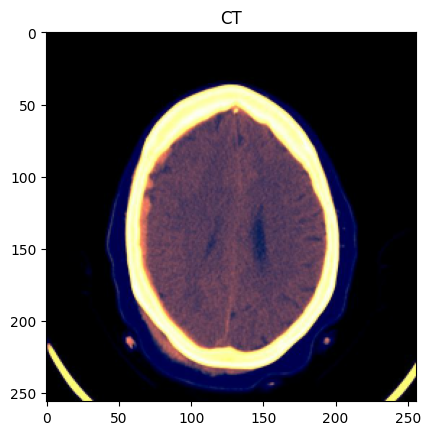

In [25]:
sample_ct = next(iter(ct_train_ds))

plt.title('CT')
plt.imshow(sample_ct[0] * 0.5 + 0.5)


In [ ]:
sample_ct

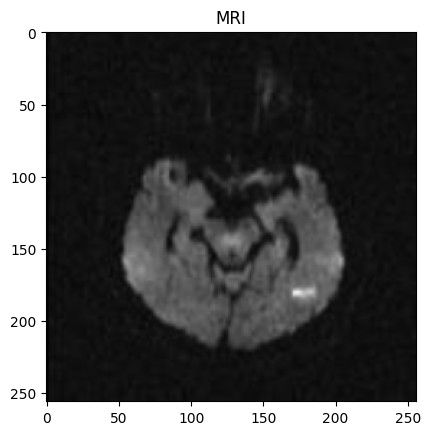

In [26]:
sample_mri = next(iter(mri_train_ds))

plt.title('MRI')
plt.imshow(sample_mri[0] * 0.5 + 0.5)


In [27]:
OUTPUT_CHANNELS = 3

generator_g = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')
generator_f = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')

discriminator_x = pix2pix.discriminator(norm_type='instancenorm', target=False)
discriminator_y = pix2pix.discriminator(norm_type='instancenorm', target=False)


In [28]:
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)


In [29]:
def discriminator_loss(real, generated):
    real_loss = loss_obj(tf.ones_like(real), real)

    generated_loss = loss_obj(tf.zeros_like(generated), generated)

    total_disc_loss = real_loss + generated_loss

    return total_disc_loss * 0.5


In [30]:
def generator_loss(generated):
    return loss_obj(tf.ones_like(generated), generated)


In [31]:
def calc_cycle_loss(real_image, cycled_image):
    loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))

    return LAMBDA * loss1


In [32]:
def identity_loss(real_image, same_image):
    loss = tf.reduce_mean(tf.abs(real_image - same_image))
    return LAMBDA * 0.5 * loss


In [33]:
generator_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)


In [34]:
checkpoint_path = ".checkpoints/"

ckpt = tf.train.Checkpoint(generator_g=generator_g,
                           generator_f=generator_f,
                           discriminator_x=discriminator_x,
                           discriminator_y=discriminator_y,
                           generator_g_optimizer=generator_g_optimizer,
                           generator_f_optimizer=generator_f_optimizer,
                           discriminator_x_optimizer=discriminator_x_optimizer,
                           discriminator_y_optimizer=discriminator_y_optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=10)


In [35]:
EPOCHS = 20

def generate_images(model, test_input):
    prediction = model(test_input)

    plt.figure(figsize=(12, 12))

    display_list = [test_input[0], prediction[0]]
    title = ['Input Image', 'Predicted Image']

    for i in range(2):
        plt.subplot(1, 2, i+1)
        plt.title(title[i])
        # getting the pixel values between [0, 1] to plot it.
        plt.imshow(display_list[i] * 0.5 + 0.5)
        plt.axis('off')
    plt.show()


In [36]:
@tf.function
def train_step(real_x, real_y):
    # persistent is set to True because the tape is used more than
    # once to calculate the gradients.
    with tf.GradientTape(persistent=True) as tape:
        # Generator G translates X -> Y
        # Generator F translates Y -> X.

        fake_y = generator_g(real_x, training=True)
        cycled_x = generator_f(fake_y, training=True)

        fake_x = generator_f(real_y, training=True)
        cycled_y = generator_g(fake_x, training=True)

        # same_x and same_y are used for identity loss.
        same_x = generator_f(real_x, training=True)
        same_y = generator_g(real_y, training=True)

        disc_real_x = discriminator_x(real_x, training=True)
        disc_real_y = discriminator_y(real_y, training=True)

        disc_fake_x = discriminator_x(fake_x, training=True)
        disc_fake_y = discriminator_y(fake_y, training=True)

        # calculate the loss
        gen_g_loss = generator_loss(disc_fake_y)
        gen_f_loss = generator_loss(disc_fake_x)

        total_cycle_loss = calc_cycle_loss(real_x, cycled_x) + calc_cycle_loss(real_y, cycled_y)

        # Total generator loss = adversarial loss + cycle loss
        total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(real_y, same_y)
        total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(real_x, same_x)

        disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
        disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)

    # Calculate the gradients for generator and discriminator
    generator_g_gradients = tape.gradient(total_gen_g_loss,
                                        generator_g.trainable_variables)
    generator_f_gradients = tape.gradient(total_gen_f_loss,
                                        generator_f.trainable_variables)

    discriminator_x_gradients = tape.gradient(disc_x_loss,
                                            discriminator_x.trainable_variables)
    discriminator_y_gradients = tape.gradient(disc_y_loss,
                                            discriminator_y.trainable_variables)

    # Apply the gradients to the optimizer
    generator_g_optimizer.apply_gradients(zip(generator_g_gradients,
                                            generator_g.trainable_variables))

    generator_f_optimizer.apply_gradients(zip(generator_f_gradients,
                                            generator_f.trainable_variables))

    discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients,
                                                discriminator_x.trainable_variables))

    discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients,
                                                discriminator_y.trainable_variables))


Epoch: 0  Step: 680

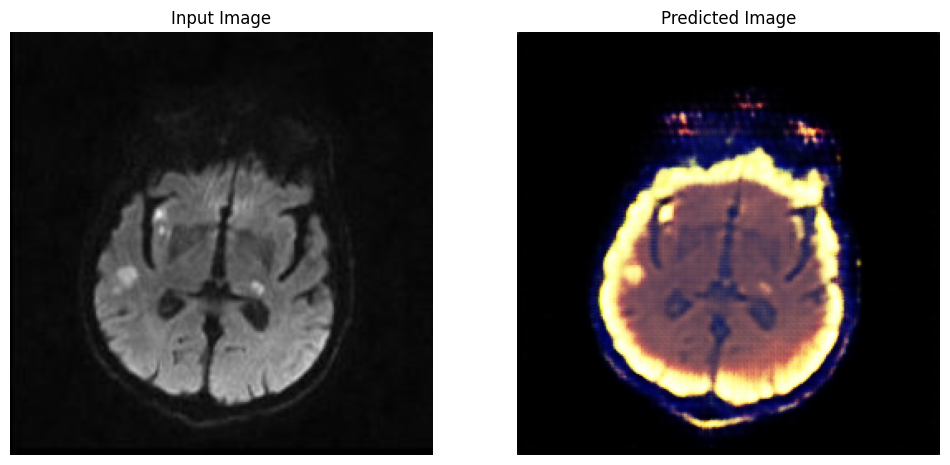

In [ ]:
LAMBDA = 10
for epoch in range(EPOCHS):
    start = time.time()

    n = 0
    for image_x, image_y in tf.data.Dataset.zip((mri_train_ds,ct_train_ds)):
        train_step(image_x, image_y)
        if n % 10 == 0:
            clear_output(wait=True)
            print ('Epoch:',epoch, " Step:", n , end='')
            generate_images(generator_g, image_x)
        elif n % 1000 == 0:
          ckpt_save_path = ckpt_manager.save()
          print ('Saving checkpoint for epoch {} at {}'.format(epoch+1, ckpt_save_path))
        n += 1


    print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,
                                                      time.time()-start))
